In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import GPy
import gp_grid
gp_grid.debug()

First generate a dataset using a random covariance in the ''network'' space and using an rbf kernel in the temporal dimension.

In [2]:
np.random.seed(0)
n_network = 3 # number of networks
n_time = 200
N = n_network*n_time

# get a random network covariance matrix
K_n = 2*np.random.rand(n_network,n_network)-1;    K_n = K_n*K_n.T + 0.1*np.identity(n_network) # make spd

# specify a time covariance function
k_t = gp_grid.kern.RBF(1, lengthscale=0.2)
k_t.constraint_map['variance'] = 'fixed'
k_t.constraint_map['lengthscale'] = 'fixed'

# create a dataset
noise_var = 1e-6
t = np.linspace(0,5,num=n_time).reshape((-1,1))
xg = [np.arange(n_network).reshape((-1,1)),t]
# x = gp_grid.grid.grid2mat(*xg) # convert from grid to actual points
yg = np.random.multivariate_normal(np.zeros(N), np.kron(K_n,k_t.cov(t))+noise_var*np.identity(N)).reshape((n_network,n_time))

[ 11:34:30 ] gp_grid.kern DEBUG: Initializing RBF kernel.


plot the network and the covariance

network covariance matrix:
[[ 0.10953103  0.03863353 -0.025655  ]
 [ 0.03863353  0.12331436  0.2286295 ]
 [-0.025655    0.2286295   0.95993262]]


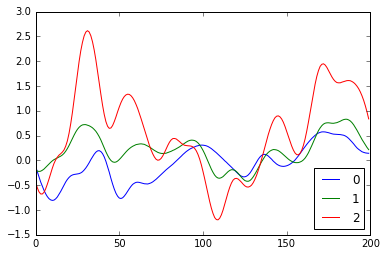

In [3]:
plt.figure()
for i in range(n_network):
    plt.plot(yg[i,:],label='%d'%i)
plt.legend(loc=0)

# plt.figure()
# plt.imshow(np.abs(K_n),interpolation='none')
print "network covariance matrix:"
print K_n

initialize the kernels with a random guess at the network covariance matrix and train the model to try and recover the original one model

In [4]:
print "exact covariance:"
print K_n

# get random covariance to initialize
# np.random.seed(5)
# K_init = 2*np.random.rand(n_network,n_network)-1; K_init = K_init.dot(K_init.T)

# compute mle covariance assuming no time dependence
K_init = np.cov(yg)

# print statistics of intial guess
print "\ninitial network covariance matrix:"
print K_init
print "\n% error between initial and exact covariance matricies:"
print (K_init-K_n) / K_n * 100

# now optimize the covariance matrix
kern_list = [gp_grid.kern.DirectCovariance(K=K_init), k_t]
m_kml = gp_grid.models.GPGridRegression(xg,yg,kern_list, noise_var=noise_var)
m_kml.noise_var_constraint = 'fixed'
m_kml.optimize()
# print m_kml
K_recovered = m_kml.kern.kern_list[0].cov(np.arange(n_network).reshape((-1,1)))
print "\noptimized network covariance matrix:"
print K_recovered
print "\nerror between optimized and exact covariance matricies:"
print K_recovered-K_n
print "\n% error between optimized and exact covariance matricies:"
print (K_recovered-K_n) / K_n * 100

# ensure that the relative error is significantly less after MLE
before_norm = np.linalg.norm((K_init-K_n) / K_n * 100)
after_norm = np.linalg.norm((K_recovered-K_n) / K_n * 100)
improvement = after_norm/before_norm
print improvement
assert improvement < 0.15, "MLE didn't sufficiently decrease the covariance error."
print "done tests!"

exact covariance:
[[ 0.10953103  0.03863353 -0.025655  ]
 [ 0.03863353  0.12331436  0.2286295 ]
 [-0.025655    0.2286295   0.95993262]]

initial network covariance matrix:
[[ 0.13441695  0.05547871  0.08960251]
 [ 0.05547871  0.10892457  0.25899592]
 [ 0.08960251  0.25899592  0.79836135]]

% error between initial and exact covariance matricies:
[[  22.72042505   43.60245751 -449.25952153]
 [  43.60245751  -11.66919171   13.28193657]
 [-449.25952153   13.28193657  -16.83152216]]
[ 11:34:31 ] gp_grid.models DEBUG: Initializing GPGridRegression model.
[ 11:34:31 ] gp_grid.models DEBUG: Beginning MLE to optimize hyperparameters. grad_method=adjoint
[ 11:34:32 ] gp_grid.models INFO: Function Evals: -2600. Exit status: 0

optimized network covariance matrix:
[[ 0.11281775  0.02416879 -0.01774662]
 [ 0.02416879  0.10044393  0.21438009]
 [-0.01774662  0.21438009  0.82492375]]

error between optimized and exact covariance matricies:
[[ 0.00328672 -0.01446475  0.00790837]
 [-0.01446475 -0.022870